In [1]:
import numpy as np
import scipy
import struct
import os
import sklearn
from matplotlib.pylab import plt
import statistics
import math
import sys
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from matplotlib import collections  as mc
from sklearn.calibration import calibration_curve

In [2]:
# read line by line with label
with open('./full_set.txt', 'r') as f:
    lines = f.readlines()
    
lines = [lin.rstrip('\n').split('\t') for lin in lines]

In [3]:
data, label = [], []
# compile a regex to remove digits and punctuations
regex1 = re.compile(r"[0-9]+")
regex2 = re.compile(r'[%s]' % re.escape(string.punctuation))
for lin in lines:
    data.append(regex2.sub('', regex1.sub('', lin[0]).lower()))
    label.append(int(lin[1]))

In [4]:
# vectorize string data using bag of words, 5000 words max
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words=['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'], 
    max_features=5000,
    )
# vectorize data
data = vectorizer.fit_transform(data)
data = data.toarray()
label = np.asarray(label)
# check same number of samples in data and label
assert(data.shape[0] == label.shape[0])

In [5]:
# divide data into training:2200, calibration:400 and test:400 sets
# with positive and negative samples balanced
pos_idx = label == 1
neg_idx = label == 0
pos, pos_lb = data[pos_idx], label[pos_idx]
neg, neg_lb = data[neg_idx], label[neg_idx]
print("Number of smaples positive:{}, negative:{}".format(len(pos), len(neg)))

# splitting dataset and shuffle
train = np.concatenate((pos[:1100], neg[:1100]), axis=0)
train_lb = np.concatenate((pos_lb[:1100], neg_lb[:1100]), axis=0)
idx = np.random.permutation(len(train))
train, train_lb = train[idx], train_lb[idx]

calib = np.concatenate((pos[1100:1300], neg[1100:1300]), axis=0)
calib_lb = np.concatenate((pos_lb[1100:1300], neg_lb[1100:1300]), axis=0)
idx = np.random.permutation(len(calib))
calib, calib_lb = calib[idx], calib_lb[idx]

test = np.concatenate((pos[1300:], neg[1300:]), axis=0)
test_lb = np.concatenate((pos_lb[1300:], neg_lb[1300:]), axis=0)
idx = np.random.permutation(len(test))
test, test_lb = test[idx], test_lb[idx]

Number of smaples positive:1500, negative:1500


## Step 1 : Learning a Classifier: SVM

In [6]:
# get bunch of C parameters to try using cross-validation
cs = np.linspace(0.01, 3.0, num=30, endpoint=True)
results = {'c':[], 'error':[]}
for c in cs:
    clf = LinearSVC(C=c, random_state=0, tol=1e-5, max_iter=5000, dual=False)
    cv_results = cross_validate(clf, train, train_lb, cv=5, return_train_score=False, n_jobs=4)
    results['error'].append(1.-np.mean(cv_results['test_score']))
    results['c'].append(c)

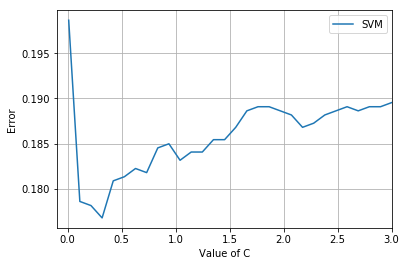

In [7]:
plt.figure()
plt.plot(results['c'], results['error'], label="SVM")
plt.xlim(-0.1, 3.0)
plt.xlabel('Value of C')
plt.ylabel('Error')
#plt.title('Variation of 5-fold cross-validated error')
plt.grid(True)
plt.legend()
plt.savefig('cversuserror.png', format='png', dpi=300)

In [8]:
# choose best C for fitting LinearSVC
C = results['c'][np.argmin(results['error'])]
svm = LinearSVC(C=C, random_state=0, tol=1e-5, max_iter=10000, dual=False)
svm.fit(train, train_lb)
print("Value of chosen C: {}".format(C))
print("Resulting error rate of SVM on test set choosing best C: {}".format(1. - svm.score(test, test_lb)))

Value of chosen C: 0.31931034482758625
Resulting error rate of SVM on test set choosing best C: 0.265


## Step 2: Learning a monotonic transformation

In [9]:
# spquashig function 
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [10]:
# gives: z = w.x + b
calib_zx = np.reshape(svm.decision_function(calib), (-1, 1))
test_zx = np.reshape(svm.decision_function(test), (-1, 1))
# squashing function 
squash_prob = sigmoid(test_zx)

# platt scaling using logistic regression
# intercept, b = 0
platt = LogisticRegression(C=1.0, max_iter=1000, fit_intercept=False)
platt.fit(calib_zx, calib_lb)
platt_prob = sigmoid(platt.coef_*test_zx + platt.intercept_)

# intercept b 
platt_b = LogisticRegression(C=1.0, max_iter=1000, fit_intercept=True)
platt_b.fit(calib_zx, calib_lb)
platt_b_prob = sigmoid(platt_b.coef_*test_zx + platt_b.intercept_)

In [11]:
# isotonic regression
isotonic = IsotonicRegression(out_of_bounds='clip')
isotonic.fit(calib_zx[:, 0], calib_lb)
isotonic_prob = isotonic.transform(test_zx[:, 0])

## Step 3: Evaluating the predicted probabilities (reliability diagram)

In [12]:
def plot_reliability_curve(lines, labels, name):
    fig, ax = plt.subplots()
    colors = ['r', 'g', 'b', 'k']
    for idx, lc in enumerate(lines):
        lc = mc.LineCollection(lc, colors=colors[idx], linewidths=2)
        ax.add_collection(lc)
        
    ax.autoscale()
    ax.margins(0.1)
    ax.legend(labels, loc='upper left')
    
    #fig.suptitle('Reliability Curve', fontsize=12)
    ax.set_xlabel('Predicted probability of y=1', fontsize=12)
    ax.set_ylabel('Actual probability of y=1', fontsize=12) 
    plt.draw()
    plt.savefig(name+'.png', format='png', dpi=300)  

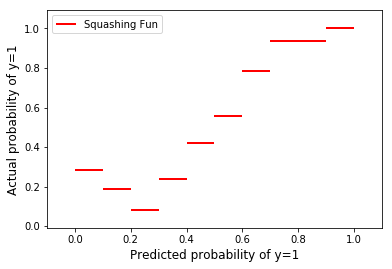

In [13]:
# squasting function plot
true_prob, _ = calibration_curve(test_lb, squash_prob, n_bins=10)
line = [[(idx/10, true_prob[idx]), (idx/10+0.1, true_prob[idx])] for idx in range(0, len(true_prob))]
plot_reliability_curve(lines=[line], labels=['Squashing Fun'], name="squash")

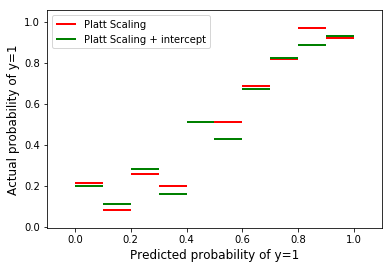

In [14]:
# platt scaling function plot
true_prob, _ = calibration_curve(test_lb, platt_prob, n_bins=10)
line1 = [[(idx/10, true_prob[idx]), (idx/10+0.1, true_prob[idx])] for idx in range(0, len(true_prob))]

true_prob, _ = calibration_curve(test_lb, platt_b_prob, n_bins=10)
line2 = [[(idx/10, true_prob[idx]), (idx/10+0.1, true_prob[idx])] for idx in range(0, len(true_prob))]

plot_reliability_curve(lines=[line1, line2], labels=['Platt Scaling', 'Platt Scaling + intercept'], name="platt")

In [15]:
true_prob

array([0.2       , 0.11111111, 0.28      , 0.15789474, 0.51111111,
       0.42857143, 0.67307692, 0.825     , 0.88888889, 0.93103448])

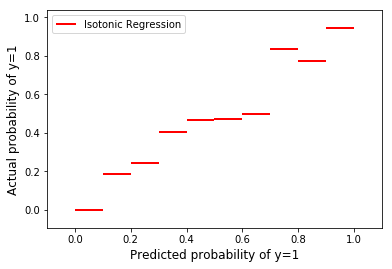

In [16]:
# isotonic regression function plot
true_prob, _ = calibration_curve(test_lb, isotonic_prob, n_bins=10)
line = [[(idx/10, true_prob[idx]), (idx/10+0.1, true_prob[idx])] for idx in range(0, len(true_prob))]
plot_reliability_curve(lines=[line], labels=['Isotonic Regression'], name="isotonic")